In [19]:
import torch
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
input_dir = '/kaggle/input/task1-24'

In [3]:
decays=['SinglePhotonPt50_IMGCROPS_n249k_RHv1','SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays):
    global input_dir

    dsets = [h5py.File(input_dir+'/'+decay+'.hdf5') for decay in decays]

    X = np.concatenate([dset['/X'] for dset in dsets]) 
    y = np.concatenate([dset['/y'] for dset in dsets])
    assert len(X) == len(y)

    return X, y

In [4]:
X,y=load_data(decays)
X = X.astype('float32') / 255.0
print(X.shape, y.shape)
X=X.transpose(0,3,1,2)

(498000, 32, 32, 2) (498000,)


In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=17)

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
X_test=torch.tensor(X_test,dtype=torch.float32);
y_test=torch.tensor(y_test,dtype=torch.float32);

In [8]:
class train_dset(Dataset):
    
    def __init__(self,X,y):
        
        self.X=X
        self.y=y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        
        return self.X[idx],self.y[idx]

In [10]:
valdset= train_dset(X_test,y_test)
valid_loader= DataLoader(traindset,batch_size=32,shuffle=True)

In [13]:
class ResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels * ResNetBlock.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * ResNetBlock.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * ResNetBlock.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * ResNetBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResNetBlock.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet15, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def resnet15():
    return ResNet15(ResNetBlock, [2, 2, 2, 1], num_classes=2)

model = resnet15()
# print(model)

### The model that was trained for 100 epochs is loaded below

In [15]:
model_weights_path = "/kaggle/input/fork-of-fork-of-ml4sci-24-task1-a2-96e817/model_resnet15.pth"

# Load the model weights
model.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode if you're doing inference
model.eval()

ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

# Validation

In [21]:
model.eval()  # Set the model to evaluation mode
y_true = []
y_scores = []

with torch.no_grad():  # Inference without gradient calculation
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Apply sigmoid if your model outputs logits
        probs = torch.sigmoid(outputs).squeeze()
        
        # Assuming the positive class is the second column
        positive_class_probs = probs[:, 1] if probs.ndim == 2 else probs
        
        # Store true labels and positive class predictions
        y_true.extend(labels.tolist())
        y_scores.extend(positive_class_probs.tolist())

# Now both y_true and y_scores are 1-dimensional
roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.9246624592637127


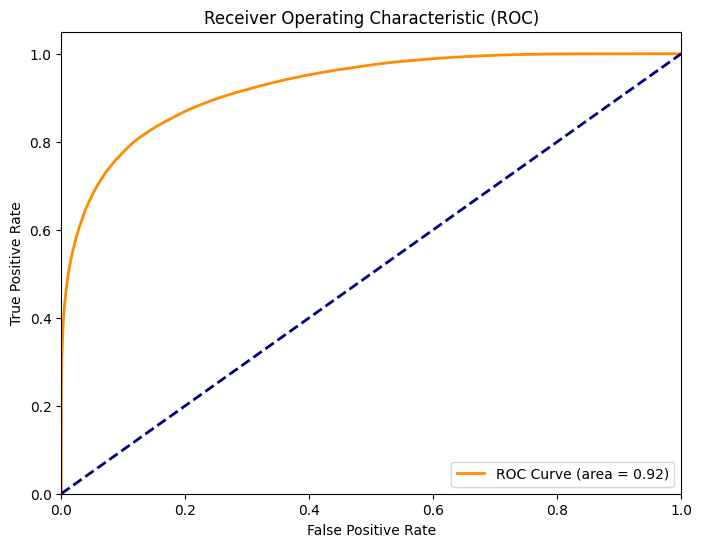

In [22]:
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()